In [0]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [0]:
!pip install transformers

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import random
import numpy as np
import glob
import os.path
import codecs
import pandas as pd
import string
import matplotlib.pyplot as plt
import time
import datetime
import seaborn as sns
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel, AdamW, BertConfig, BertTokenizer, AutoTokenizer, AutoModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import torch.nn as nn

seed_val = 16
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True
root_path = "/content/drive/My Drive/"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
dataset_path = root_path + "causal_datasets_with_features/"
train_csv = dataset_path + "unbalanced_train_dataset_80_20.csv"
dev_csv = dataset_path + "unbalanced_dev_dataset_80_20.csv"

df_train = pd.read_csv(train_csv)
df_dev = pd.read_csv(dev_csv)

In [0]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(root_path + 'bert_causal_oversimplification/bert_modified_loss_ep8/', do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
train_sent = df_train['Sentences'].values
train_labels = df_train['Labels'].values
dev_sent = df_dev['Sentences'].values
dev_labels = df_dev['Labels'].values

print(train_sent.shape)
print(train_labels.shape)
print(dev_sent.shape)
print(dev_labels.shape)

(5061,)
(5061,)
(1072,)
(1072,)


In [0]:
def get_bert_inputs(sentences):
  input_ids = []
  for sent in sentences:
      encoded_sent = tokenizer.encode(
                          sent,                      
                          add_special_tokens = True,
                          max_length = 200,   #Works well for causal local data split.
                          pad_to_max_length = True
                    )
      input_ids.append(encoded_sent)
  attention_masks = []
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)
  
  return input_ids, attention_masks

def get_additional_features(df):
  framenet_causal = df['Framenet causal score'].values
  causal_links_presence = df['Causal link presence'].values
  #causal_verbs_presence= df['Causal verb presence'].values
  pretrained_classifier_score = df['Pre-trained causal classifier labels'].values
  return framenet_causal, causal_links_presence, pretrained_classifier_score

In [0]:
train_input_ids, train_attention_masks = get_bert_inputs(train_sent)
dev_input_ids, dev_attention_masks = get_bert_inputs(dev_sent)

In [0]:
train_framenet_causal, train_causal_links, train_pretrained_label = get_additional_features(df_train)
dev_framenet_causal, dev_causal_links, dev_pretrained_label = get_additional_features(df_dev)

In [0]:
train_input_ids = torch.tensor(train_input_ids)
train_attention_masks = torch.tensor(train_attention_masks)
train_framenet_causal = torch.tensor(train_framenet_causal, dtype=torch.float)
train_causal_links = torch.tensor(train_causal_links, dtype=torch.float)
train_pretrained_label = torch.tensor(train_pretrained_label, dtype=torch.float)
train_labels = torch.tensor(train_labels)

In [0]:
dev_input_ids = torch.tensor(dev_input_ids)
dev_attention_masks = torch.tensor(dev_attention_masks)
dev_framenet_causal = torch.tensor(dev_framenet_causal, dtype=torch.float)
dev_causal_links = torch.tensor(dev_causal_links, dtype=torch.float)
dev_pretrained_label = torch.tensor(dev_pretrained_label, dtype=torch.float)
dev_labels = torch.tensor(dev_labels)

In [0]:
batch_size = 16

train_data = TensorDataset(train_input_ids, train_attention_masks, train_framenet_causal, train_causal_links, train_pretrained_label, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [0]:
class ClassifierForPropagandaDetection(nn.Module):
    def __init__(self, num_labels=2):
        super(ClassifierForPropagandaDetection, self).__init__()
        self.num_labels = num_labels
        self.bert_model = BertModel.from_pretrained(root_path + 'bert_causal_oversimplification/bert_modified_loss_ep8/')
        #self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.ffnn = nn.Sequential(nn.Dropout(p=0.1), nn.Linear(771, 400), nn.ReLU(), nn.Linear(400, self.num_labels, bias=False))

    def forward(self, input_ids,  attention_mask, framenet_causal, causal_links, pretrained_label):
        outputs = self.bert_model(input_ids, attention_mask=attention_mask, token_type_ids=None)
        last_hidden_state = outputs[0]
        pooled_output = outputs[1]
        framenet_causal = torch.unsqueeze(framenet_causal, 1)
        causal_links = torch.unsqueeze(causal_links, 1)
        pretrained_label = torch.unsqueeze(pretrained_label, 1)
        features_to_concat = (pooled_output, framenet_causal, causal_links, pretrained_label)
        features = torch.cat(features_to_concat, 1)
        logits = self.ffnn(features)
        return logits

model = ClassifierForPropagandaDetection()

In [0]:
epochs = 1
total_steps = len(train_dataloader) * epochs

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
import torch.optim as optim

for p in model.bert_model.parameters():
    p.requires_grad = False

optimizer = optim.Adam(model.ffnn.parameters())

In [0]:
loss_function = nn.CrossEntropyLoss(torch.FloatTensor([0.5241, 10.8605]))
loss_values = []

model = model.to('cuda')
loss_function = loss_function.to('cuda')

for epoch_i in range(0, epochs):
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training')
    t0 = time.time()
    total_loss = 0
    model.ffnn.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_framenet_causal = batch[2].to(device)
        b_causal_links = batch[3].to(device)
        b_pretrained_label = batch[4].to(device)
        b_labels = batch[5].to(device)
        
        model.ffnn.zero_grad()        
        logits = model(b_input_ids, b_input_mask, b_framenet_causal, b_causal_links, b_pretrained_label)

        loss = loss_function(logits, b_labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")


======== Epoch 1 / 1 ========
Training
  Batch    40  of    317.    Elapsed: 0:00:08.
  Batch    80  of    317.    Elapsed: 0:00:17.
  Batch   120  of    317.    Elapsed: 0:00:26.
  Batch   160  of    317.    Elapsed: 0:00:35.
  Batch   200  of    317.    Elapsed: 0:00:44.
  Batch   240  of    317.    Elapsed: 0:00:54.
  Batch   280  of    317.    Elapsed: 0:01:03.

  Average training loss: 0.01
  Training epoch took: 0:01:12

Training complete!


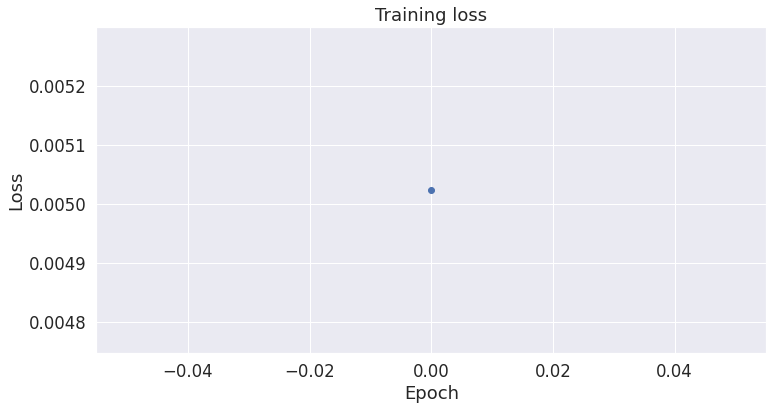

In [0]:
% matplotlib inline

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [0]:
test_csv = dataset_path + "climate_change_data.csv"

df_test = pd.read_csv(test_csv)

test_sent = df_test['Sentences'].values
test_input_ids, test_attention_masks = get_bert_inputs(test_sent)
test_framenet_causal, test_causal_links, test_pretrained_label = get_additional_features(df_test)

test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_framenet_causal = torch.tensor(test_framenet_causal, dtype=torch.float)
test_causal_links = torch.tensor(test_causal_links, dtype=torch.float)
test_pretrained_label = torch.tensor(test_pretrained_label, dtype=torch.float)

In [0]:
batch_size = 32  

prediction_data = TensorDataset(dev_input_ids, dev_attention_masks, dev_framenet_causal, dev_causal_links, dev_pretrained_label)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

test_prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_framenet_causal, test_causal_links, test_pretrained_label)
test_prediction_sampler = SequentialSampler(test_prediction_data)
test_prediction_dataloader = DataLoader(test_prediction_data, sampler=test_prediction_sampler, batch_size=batch_size)

In [0]:
print('Predicting labels for {:,} test sentences...'.format(len(dev_input_ids)))
model.ffnn.eval()

predictions = []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_framenet_causal, b_causal_links, b_pretrained_label = batch
  with torch.no_grad():
      logits = model(b_input_ids, b_input_mask, b_framenet_causal, b_causal_links, b_pretrained_label)
  logits = logits.detach().cpu().numpy()
  predictions = predictions + list(logits)

print('Done!')

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))
model.ffnn.eval()

test_predictions = []

for batch in test_prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_framenet_causal, b_causal_links, b_pretrained_label = batch
  with torch.no_grad():
      logits = model(b_input_ids, b_input_mask, b_framenet_causal, b_causal_links, b_pretrained_label)
  logits = logits.detach().cpu().numpy()
  test_predictions = test_predictions + list(logits)

print('Done!')

Predicting labels for 1,072 test sentences...
Done!
Predicting labels for 4,349 test sentences...
Done!


In [0]:
predicted_labels = []
for i in range(len(predictions)):
    pred_value = np.argmax(predictions[i])
    if pred_value > 1:
        raise Exception("Error in predictions")
    predicted_labels.append(pred_value)

print(predicted_labels)

test_predicted_labels = []
for i in range(len(test_predictions)):
    test_pred_value = np.argmax(test_predictions[i])
    if test_pred_value > 1:
        raise Exception("Error in predictions")
    test_predicted_labels.append(test_pred_value)

print(test_predicted_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [0]:
df_test['Predictions - Causal oversimplification'] = test_predicted_labels
df_test.to_csv(dataset_path + "climate_change_with_predictions.csv")

In [0]:
print("Accuracy of classifier - ", accuracy_score(dev_labels, predicted_labels))

Accuracy of classifier -  0.9496268656716418


In [0]:
print("Confusion matrix values - ")
tn, fp, fn, tp = confusion_matrix(dev_labels, predicted_labels).ravel()
print("TP - ", tp)
print("FN - ", fn)
print("TN - ", tn)
print("FP - ", fp)

Confusion matrix values - 
TP -  5
FN -  37
TN -  1013
FP -  17


In [0]:
print("F1-score of classifier on each class - ", f1_score(dev_labels, predicted_labels, average=None))
print("Macro averaged F1-score of classifier - ", f1_score(dev_labels, predicted_labels, average='macro'))
print("Weighted averaged F1-score of classifier - ", f1_score(dev_labels, predicted_labels, average='weighted'))

F1-score of classifier on each class -  [0.97403846 0.15625   ]
Macro averaged F1-score of classifier -  0.5651442307692307
Weighted averaged F1-score of classifier -  0.9419982419632605
